### To do 

gal['data'].shape = 3, npix, npix -> gal['img'], gal['mask'], gal['weight'].   'mask' needs to be boolean.

In [1]:
import matplotlib as mpl
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import pickle

import astrobf
from astrobf.utils import mask_utils
from astrobf.utils.mask_utils import *
from astrobf.utils import gen_mask
from astrobf.morph import measure_morph

from astrobf.run import Full_exp
from astrobf.analysis.binary_clustering import *
from astrobf.analysis.utils import *

from astrobf.morph import custom_morph
from astrobf.analysis import multi_clustering as mucl
from astrobf.analysis.multi_clustering import labeler



#import statmorph
import time

import random
import importlib

mpl.rcParams['savefig.facecolor'] = 'white'

## AX
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.ax_client import AxClient

## 1. Load the all-in-one data

### All_gals data

all-gals is a list of dictionaries, each of which contains 
(ndarray image, string image_name, and slices slice)


In [2]:
fn = "../../bf_data/Nair_and_Abraham_2010/all_gals.pickle"
all_gals = pickle.load(open(fn, "rb"))

all_gals = all_gals[1:] # Why the first galaxy image is NaN?

### 2. Load galaxy catalog data and initial morph measurements

Just in case, only for the initial morphology measurement, full results are saved. 

In [16]:
asym_center = pickle.load(open("./mean_center_asym.pickle", "rb"))

for ag in all_gals:
    ind = np.where(asym_center['id'] == ag['img_name'])[0]
    ag.update({'asym_center':np.array((asym_center['xc_asym'][ind],
                                       asym_center['yc_asym'][ind])).squeeze()})


In [17]:
from astrobf.utils.misc import load_Nair
importlib.reload(astrobf.utils.misc)

cat_data = load_Nair('../../bf_data/Nair_and_Abraham_2010/catalog/table2.dat')
# pd dataframe

good_gids = np.array([gal['img_name'] for gal in all_gals])
cat = cat_data[cat_data['ID'].isin(good_gids)]
# Leave only needed fields.

In [18]:
## Runtime config.

fields = ['gini', 'm20', 'asymmetry']#, 'concentration', 'asymmetry', 'smoothness']
label_field = 'TT'

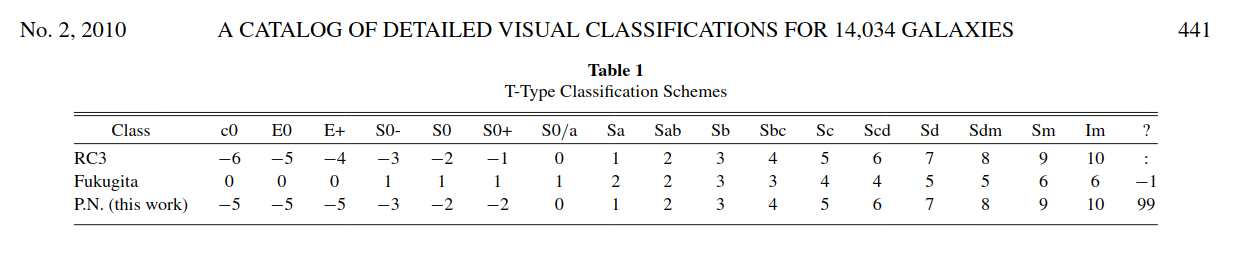

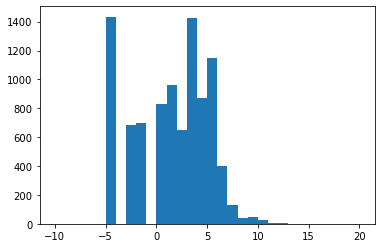

In [4]:
plt.hist(cat['TT'], range=[-10,20], bins=30)
plt.show()

2 groups : [-5, -1],        [3,5]

4 groups : [-5, -1], [0,2], [3,5], [6,9]  

6 groups : [-5,-5], [-3, -1], [0,2], [3,4], [5,6], [7,9]

8 groups : [-5,-5], [-3, -1], [0,1], [2,3], [4,5], [6,7], [8,9], [10, ~]

# Run Bayesian Optimization loop

### Initialize BO loop -  Measure morphology features

Catalog에서 outlier를 버렸으므로 원래의 catalog/all_gals보다 길이가 짧은 result_arr가 나옴. 
시작할 때 sample을 정하고, 나머지는 잘라버린 뒤에 optimization을 수행하는게 맞을 듯. 

그럼 good_gids도 업데이트해야됨. 


이거 머리 아프니까 한 덩어리로 합치면 좋겠는데.! 

class dataset():
    def __init__(self):

### Test evaluate

Need to be dl > dh ? 

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10



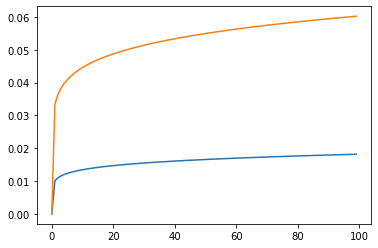

In [51]:
from astrobf.tmo import Mantiuk_Seidel
for i in [0,1]:
    plt.plot(Mantiuk_Seidel(np.linspace(0,100,100), **mucl.ext_single_param(params, f"{i}")))

In [6]:
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [12]:
from functools import partial

def evaluate(params, cluster_method="agglomerate", eval_method='sample-weighted FMS', debug=False):
    plist =[{'b':params[f'b{i}'],
             'c':params[f'c{i}'],
            'dl':params[f'dl{i}'],
            'dh':params[f'dh{i}']} for i in range(ngroups)]

    result_list = []
    for i in range(ngroups):
        result_list.append(mucl.get_morph(sub_gals, 
                                          plist[i], 
                                          np.where(subcat['label'] == i)[0],
                                          fields)
                                          )
        if "bad" in result_list[-1]:
            return {"mymetric": (-1, 0), "total_flux":(0,0)}
    
    # merge and sort
    result_arr = np.concatenate(result_list)
    result_arr = result_arr[np.argsort(result_arr['id'])] # Sort first to apply 'searchsorted'
    inds = result_arr['id'].searchsorted(subcat["ID"])
    result_arr = result_arr[inds]
    
    Full_exp.add_ttype(result_arr, subcat)
    
    eval_metrics = Full_exp.do_ML(result_arr, partial(labeler, bins=this_bin), subcat, n_clusters=ngroups,
                                  fields=fields, 
                                  cluster_method=cluster_method,
                                  eval_weight='area')
    
    # save all metrics to a global list.
    all_metrics.append(eval_metrics)
    #mymetric = eval_metrics[0][1] # Homogenity
    #return eval_metrics
    clustering_score = [val for (name, val) in eval_metrics if name == eval_method][0]
    stderr = 0.0
    return {"mymetric": (clustering_score, stderr), "total_flux":(1,0)}

# Test evaluate

In [8]:
# 0.45x is the lowest value of maximum flux of all images.
exp_dir='./Experiments/'
#for ngroups in [1:]:
ngroups = [2,4,6,8][1]

this_bin, bin_mask = mucl.gen_bin_n_mask(ngroups)        
ax_params = mucl.gen_tmo_param_sets(ngroups)

subcat = mucl.sample_in_bins(cat, ngroups, this_bin, bin_mask=bin_mask)
subcat = subcat

print("# of sub sample: {}".format(len(subcat)))

sub_gals = [gal for gal in all_gals if gal['img_name'] in subcat['ID']]


fn_result = f"FMS_{ngroups}G_ward_asym"
cluster_method = 'ward'

all_metrics = pickle.load(open(exp_dir+fn_result+"_all_metrics.pickle", "rb"))
axc = AxClient.load_from_json_file(exp_dir+fn_result+'.json')

/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# of sub sample: 9313


[INFO 06-06 15:53:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 333_0, 241_0, 214_0, 211_0, 220_0, 343_0, 178_0, 189_0, 340_0, 317_0, 95_0, 388_0, 133_0, 316_0, 227_0, 367_0, 191_0, 389_0, 255_0, 257_0, 206_0, 330_0, 326_0, 380_0, 198_0, 98_0, 86_0, 280_0, 242_0, 337_0, 396_0, 272_0, 315_0, 312_0, 84_0, 134_0, 350_0, 397_0, 339_0, 345_0, 355_0, 338_0, 399_0, 331_0, 347_0, 156_0, 398_0, 377_0, 378_0, 279_0, 379_0, 135_0, 182_0, 361_0, 177_0, 186_0, 321_0, 204_0, 291_0, 395_0, 323_0, 258_0, 146_0, 168_0, 392_0, 318_0, 83_0, 387_0, 132_0, 165_0, 273_0, 167_0, 314_0, 302_0, 381_0, 259_0, 372_0, 363_0, 386_0, 163_0, 341_0, 274_0, 148_0, 320_0, 205_0, 267_0, 147_0, 207_0, 208_0, 271_0, 394_0, 336_0, 216_0, 391_0, 322_0, 268_0, 351_0, 375_0, 218_0, 221_0, 335_0, 250_0, 327_0, 360_0, 228_0, 252_0, 93_0, 357_0, 366_0, 364_0, 275_0, 382_0, 393_0, 96_0, 88_0, 90_0, 196_0, 374_0, 137_0, 94_0, 187_0, 164_0, 154_0, 136_0
[INFO 06-06 15:53:26] ax.service.ax_client: Startin

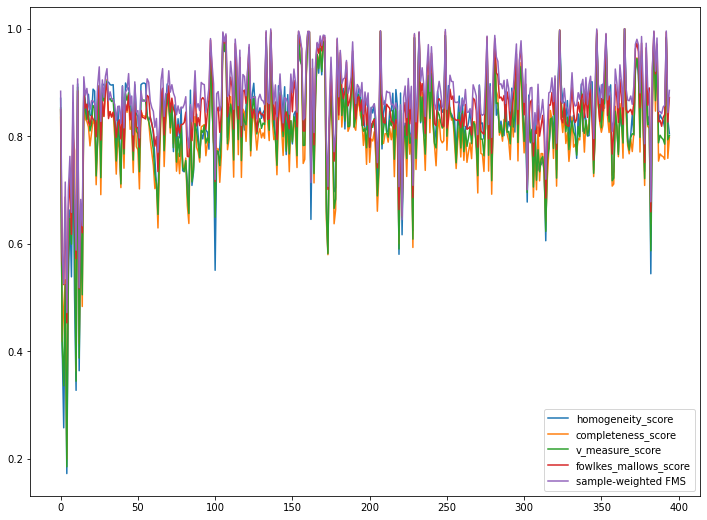

[INFO 06-06 15:53:39] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


     Generation Step Generation Model  Trial Index Trial Status  \
0                  0            Sobol            0    COMPLETED   
1                  0            Sobol            1    COMPLETED   
2                  0            Sobol            2    COMPLETED   
3                  0            Sobol            3    COMPLETED   
4                  0            Sobol            4    COMPLETED   
..               ...              ...          ...          ...   
395                1             GPEI          395    COMPLETED   
396                1             GPEI          396    COMPLETED   
397                1             GPEI          397    COMPLETED   
398                1             GPEI          398    COMPLETED   
399                1             GPEI          399    COMPLETED   

                                 Arm Parameterizations  
0    {'0_0': {'b0': 2.04, 'c0': 6.24, 'dl0': 12.25,...  
1    {'1_0': {'b0': 6.58, 'c0': 1.77, 'dl0': 10.47,...  
2    {'2_0': {'b0': 3.98

<Figure size 432x288 with 0 Axes>

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(12,9)
for i in [0,1,2,5,9]:
    values =[al[i][1] for al in all_metrics] 
    ax.plot(values / np.max(values), label=all_metrics[0][i][0])
ax.legend()
plt.show()
plt.savefig(fn_result+"param_evol.png")

print(axc.generation_strategy.trials_as_df)
render(axc.get_optimization_trace())

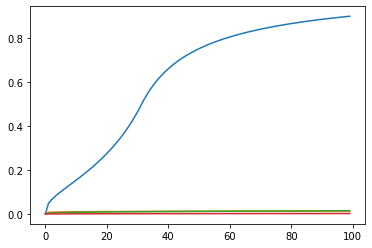

In [10]:
best_parameters, values = axc.get_best_parameters()
from astrobf.tmo import Mantiuk_Seidel
for i in range(ngroups):
    plt.plot(Mantiuk_Seidel(np.linspace(0,100,100), **mucl.ext_single_param(best_parameters, f"{i}")))
    

parameters들 normalize가 안 된듯?? 
각각의 모양은 그럴싸함. 

## Prototypical samples

In [19]:
from astrobf import analysis

best_parameters, values = axc.get_best_parameters()

plist = [mucl.ext_single_param(best_parameters, f"{i}") for i in range(ngroups)]

subcat = mucl.sample_in_bins(cat, ngroups, this_bin, bin_mask=bin_mask)

print("# of sub sample: {}".format(len(subcat)))

sub_gals = [gal for gal in all_gals if gal['img_name'] in subcat['ID']]


best_results = []
for i in range(ngroups):
    best_results.append(mucl.get_morph(sub_gals, 
                                 plist[i], 
                                 np.where(subcat['label'] == i)[0],
                                 fields))

# merge and sort
best_results = np.concatenate(best_results)
best_results = best_results[np.argsort(best_results['id'])] # Sort first to apply 'searchsorted'
inds = best_results['id'].searchsorted(subcat["ID"])
best_results = best_results[inds]
#best_results = Full_exp.run_morph_in_parts(sub_gals, subcat, plist, ngroups)

/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# of sub sample: 9313
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


In [22]:
#best_results = custom_morph.step_simple_morph(all_gals, best_parameters)
Full_exp.add_ttype(best_results, subcat)

nbest_eval_metrics, best_clustering = Full_exp.do_ML(best_results, partial(labeler, bins=this_bin),
                                                     subcat, n_clusters=ngroups,
                                                     return_cluster=True,
                                                      fields=fields, 
                                                      cluster_method=cluster_method,
                                                      eval_weight='area')

Is every element matched?:  True


9313


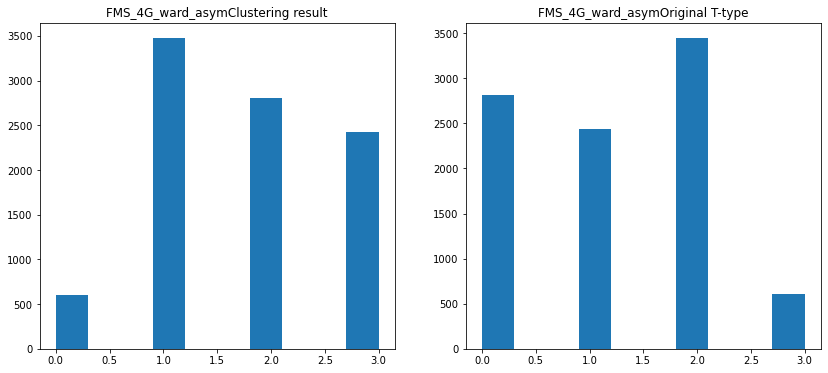

In [24]:
print(len(best_clustering.labels_))
fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,6)

axs[0].hist(best_clustering.labels_)
axs[0].set_title(fn_result+"Clustering result")
axs[1].hist(labeler(subcat, bins=this_bin, field='TT'))
axs[1].set_title(fn_result+"Original T-type")

plt.show()

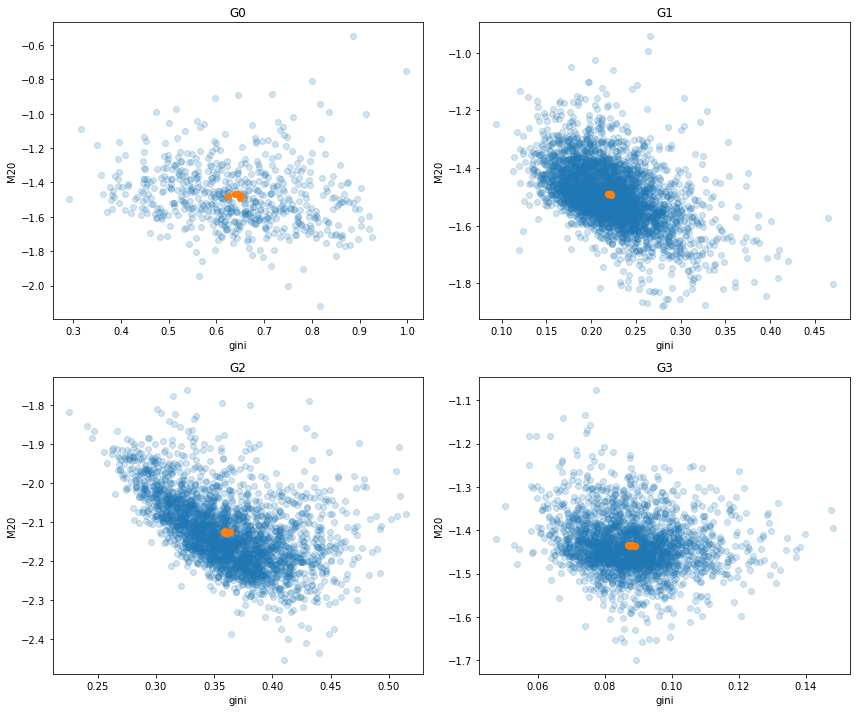

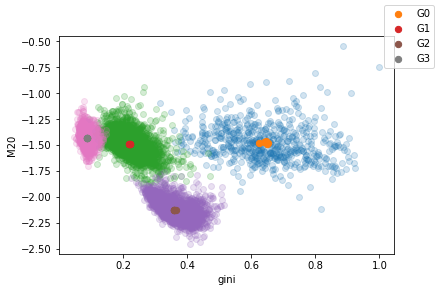

In [25]:
# Get centroids (typicals)
typicals = []

fig, axs = plt.subplots(2,2)
axs = axs.ravel()
fig.set_size_inches(12,10)

fig_sum, ax_sum = plt.subplots()
for i in range(ngroups):
    ax = axs[i]
    group = best_results[best_clustering.labels_ == i]
    
    t_ind = analysis.utils.get_typical_ind(group, n_samples=5)
    ax.scatter(group['gini'], group['m20'], alpha=0.2)
    ax.scatter(group['gini'][t_ind], group['m20'][t_ind], s=40)
    ax.set_xlabel("gini")
    ax.set_ylabel("M20")
    ax.set_title(f"G{i}")
    
    typicals.append([gal for gal in sub_gals if gal['img_name'] in group['id'][t_ind]])
    
    
    # all in one plot
    ax_sum.scatter(group['gini'], group['m20'], alpha=0.2)
    ax_sum.scatter(group['gini'][t_ind], group['m20'][t_ind], s=40, label=f"G{i}")
    ax_sum.set_xlabel("gini")
    ax_sum.set_ylabel("M20")


fig.tight_layout()
fig_sum.legend()
plt.show()

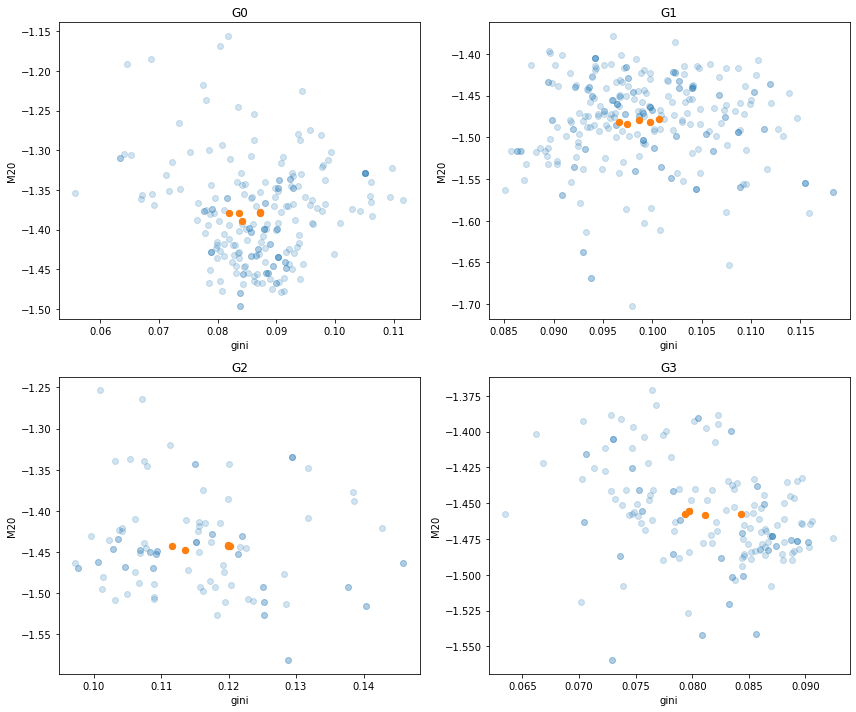

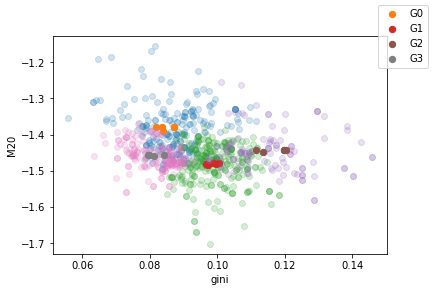

In [36]:
# Get centroids (typicals)
typicals = []

fig, axs = plt.subplots(2,2)
axs = axs.ravel()
fig.set_size_inches(12,10)

fig_sum, ax_sum = plt.subplots()
for i in range(ngroups):
    ax = axs[i]
    group = best_results[best_clustering.labels_ == i]
    
    t_ind = analysis.utils.get_typical_ind(group, n_samples=5)
    ax.scatter(group['gini'], group['m20'], alpha=0.2)
    ax.scatter(group['gini'][t_ind], group['m20'][t_ind], s=40)
    ax.set_xlabel("gini")
    ax.set_ylabel("M20")
    ax.set_title(f"G{i}")
    
    typicals.append([gal for gal in sub_gals if gal['img_name'] in group['id'][t_ind]])
    
    
    # all in one plot
    ax_sum.scatter(group['gini'], group['m20'], alpha=0.2)
    ax_sum.scatter(group['gini'][t_ind], group['m20'][t_ind], s=40, label=f"G{i}")
    ax_sum.set_xlabel("gini")
    ax_sum.set_ylabel("M20")


fig.tight_layout()
fig_sum.legend()
plt.show()

In [21]:
mucl.plot_group_comparison(typicals, plist, ngroups,
                          fn=exp_dir+fn_result+"groups_comp.png")

mucl.plot_group_comparison(typicals, plist, ngroups, simple_log=True,
                          fn=exp_dir+fn_result+"groups_log.png")


/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:80: RuntimeWarning:

divide by zero encountered in log10



## Typical sampes at incremental points 

### Get the 'incremental' points

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



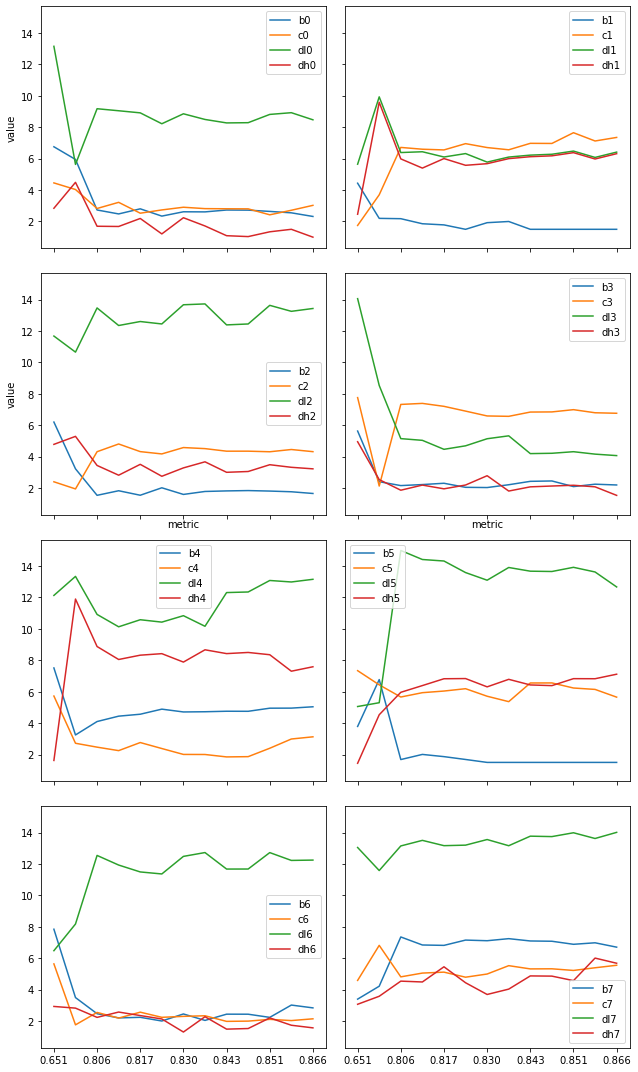

In [24]:
trace, t_ = axc.get_optimization_trace()

scores = np.array(trace['data'][0]['y'])
i_incr = [np.argmax(sc == scores) for sc in np.unique(scores)]

incr_params = [axc.get_trial_parameters(i) for i in i_incr]

# Change of the parameters over time
param_arr = np.zeros(len(incr_params), dtype=[(key, 'f') for key in incr_params[0].keys()])

for i, params in enumerate(incr_params):
    for key, val in params.items():
        param_arr[key][i] = val

fig,axs = plt.subplots(4,2, sharex=True, sharey=True)
fig.set_size_inches(9,15)
axs = axs.ravel()
for i in range(ngroups):    
    ax = axs[i]
    for field in param_arr.dtype.names:
        if f"{i}" in field:
            ax.plot(param_arr[field], label=field)

    ax.set_xticklabels([f"{scores[i]:.3f}" for i in i_incr])
    ax.legend()
axs[2].set_xlabel("metric")
axs[3].set_xlabel("metric")
axs[0].set_ylabel("value")
axs[2].set_ylabel("value")
plt.tight_layout()
plt.savefig(fn_result+"param_evol.png")
plt.show()

Interestingly, the changes are somewhat unpredictable.

### Typical samples at each incremental point

TODO : support arbitrary numebr of clusters. 

In [162]:
importlib.reload(mucl)

<module 'astrobf.analysis.multi_clustering' from '/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py'>

In [25]:
# Typicals defined above

clu_best = [best_results[best_clustering.labels_ == i] for i in range(ngroups)] 
typical_best_results = [analysis.utils.get_matched_result(best_results, 
                                               [gal['img_name'] for gal in tt]) for tt in typicals]

for i, this_params in enumerate(incr_params):
    
    plist = [mucl.ext_single_param(this_params, f"{i}") for i in range(ngroups)]
    
    mucl.plot_group_comparison(typicals, plist, ngroups,
                          fn=fn_result+f'typical_{i}.png',
                          suptitle=f"scroe: {scores[i_incr[i]]:.4f}")

    this_results = Full_exp.run_morph_in_parts(sub_gals, subcat, plist, ngroups)
    Full_exp.add_ttype(this_results, subcat)

    eval_metrics, this_clustering = Full_exp.do_ML(this_results, partial(labeler, bins=this_bin), subcat,
                                     fields=['gini', 'm20'], 
                                     n_clusters=ngroups,
                                     return_cluster=True,
                                     cluster_method=cluster_method,
                                     eval_weight='area')

    typical_this_results = [(analysis.utils.get_matched_result(this_results, 
                                               [gal['img_name'] for gal in tt])) for tt in typicals]
    clu_this = [this_results[this_clustering.labels_ == i] for i in range(ngroups)] 
    mucl.plot_group_evals_w_centers(clu_best, 
                           typical_best_results,
                           clu_this, 
                           typical_this_results,
                           fn=fn_result+f"G_M{i}.png")

    mucl.plot_classification_vs_answer(this_results, clu_best, partial(labeler, bins=this_bin),
                                    fn=fn_result+f"current_in_best_color{i}.png")

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


## Backup

In [17]:
from functools import partial

def evaluate_org(params, cluster_method="agglomerate", eval_method='sample-weighted FMS'):
    plist =[{'b':params[f'b{i}'],
             'c':params[f'c{i}'],
            'dl':params[f'dl{i}'],
            'dh':params[f'dh{i}']} for i in range(ngroups)]

    result_list = []
    for i in range(ngroups):
        result_list.append(custom_morph.step_simple_morph(sub_gals, 
                                                          plist[i], 
                                                          np.where(subcat['label'] == i)[0]))
        if "bad" in result_list[-1]:
            return {"mymetric": (-1, 0), "total_flux":(0,0)}
    
    # merge and sort
    result_arr = np.concatenate(result_list)
    result_arr = result_arr[np.argsort(result_arr['id'])] # Sort first to apply 'searchsorted'
    inds = result_arr['id'].searchsorted(subcat["ID"])
    result_arr = result_arr[inds]
    
    Full_exp.add_ttype(result_arr, subcat)
    
    eval_metrics = Full_exp.do_ML(result_arr, partial(labeler, bins=this_bin), subcat, n_clusters=ngroups,
                                  fields=['gini', 'm20'], 
                                  cluster_method=cluster_method,
                                  eval_weight='area')
    
    # save all metrics to a global list.
    all_metrics.append(eval_metrics)
    #mymetric = eval_metrics[0][1] # Homogenity
    clustering_score = [val for (name, val) in eval_metrics if name == eval_method][0]
    stderr = 0.0
    return {"mymetric": (clustering_score, stderr), "total_flux":(1,0)}